# Notebook Instructions

### Before Running the Notebook:

1. **Update File Paths:**
   - Ensure that the paths to the files used in this notebook are up-to-date.

2. **Create 'crops' Folder:**
   - Create a folder named 'crops' using the code at [link](https://github.com/aequitas-aod/experiments-synthetic-generation-clinical-skin-images) that contains approximately 12,000 crops of pictures (important). The files in the dataset should follow the naming convention:
     - 0001.png and 0001_mask.png
     - ...
     - 11994.png and 11994_mask.png

3. **Diffusers Repository:**
   - Obtain a modified version of the diffusers repository available on my GitHub [here](https://github.com/mowhammadrezaa/diffusers).

### Process Overview:

4. **Process Steps:** The notebook involves the following steps:
     1. Creating new masks
     2. Extracting skin tones using the new masks
     3. Creating crops-specific prompts based on the skin tones
     4. Integrating images in the 'crops' folder with new masks and their respective prompts into a dataset
     5. Utilizing code from the GitHub repository to feed the dataset to the model
     6. Configuring the model with the respective parameters
     7. Training the controlnet model
     8. Depicting some results using the trained network.
     9. Loading the testset and applying some metrics to illustrate the performance of the trained controlnet.

### Important Note:
-  It's important to note that despite following the instructions, some errors may still occur. In such cases, carefully follow the error instructions for easy resolution by installing or making the necessary changes as indicated. It's worth mentioning that this is not a Docker container, and issues may arise.

### Next Steps:
- Proceed with the notebook, following the step-by-step instructions provided within each section.


# Install necessary libraries

In [ ]:
%%capture
# !pip install --upgrade torch
# !pip install --upgrade torchvision
# !pip install --upgrade transformers
# !pip install --upgrade diffusers
# !pip install --upgrade torchmetrics
# !pip install --upgrade accelerate
# !pip install --upgrade lightning
# !pip install --upgrade matplotlib
# !pip install --upgrade torchmetrics[image]
# !pip install --upgrade opencv_python
# !pip install tabulate

# Import necessary packages

In [1]:
import os
import numpy as np
import cv2
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from PIL import Image
from datasets import Dataset
from pathlib import Path


import torch
from diffusers import (
    ControlNetModel, 
    StableDiffusionControlNetPipeline,
    AutoencoderKL,
    UniPCMultistepScheduler
)

from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

import random

2023-12-07 16:09:49.165156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 16:09:49.300882: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-07 16:09:49.334011: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 16:09:50.021569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

# 1. Creating new masks

The following line will create the new masks and store them in the folder named 'crops_masks' in the current directory.

In [11]:
!python create_masks.py
!cp crops/*[!_mask].png crops_masks/

# 2. Extracting skin tones

## 2.1 Extracting skin tones using the new masks

In [19]:
def extract_skin_tone(img, mask):
    """
    Calculate Skin Color Approximation

    This function utilizes a provided mask to disregard imperfections in the image.
    It computes the average pixel intensities over the remaining areas, 
    producing a single intensity value for each color channel (Red, Green, and Blue). 
    The combination of these three channels yields a reliable approximation for the skin color.

    Returns:
        A tuple (R, G, B) representing the calculated skin color intensities.
    """
    
    # Apply the mask to the image
    masked_channels = np.stack([cv2.bitwise_and(img[..., i], img[..., i], mask=255-mask) for i in range(3)])
    # Calculate the mean of non-black pixels in the masked image
    r_mean, g_mean, b_mean = [int(np.mean(masked_channels[i, ...][masked_channels[i]!=0])) for i in range(3)]
    
    return r_mean, g_mean, b_mean

In [20]:
# Initialize lists to store color intensities
skin_colors = {'reds': [], 'greens': [], 'blues': []}

# Process images and masks
for i in tqdm(range(1, 11995)):
    # Format image number
    image_number = str(i).zfill(4)
    
    # Read image and mask
    image = cv2.imread(f'crops_masks/{image_number}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image_mask = cv2.imread(f'crops_masks/{image_number}_mask.png')
    image_mask = cv2.cvtColor(image_mask, cv2.COLOR_BGR2RGB)
    
    # Extract skin tone from the image
    r, g, b = extract_skin_tone(image, image_mask[..., 0])
    
    # Update mask channels with skin tone values
    # image_mask[..., 0][image_mask[..., 0] == 255] = b
    # image_mask[..., 1][image_mask[..., 1] == 255] = g
    # image_mask[..., 2][image_mask[..., 2] == 255] = r
    
    # Save colored mask
    # cmask = image_mask
    # cv2.imwrite(f'crops_masks/{image_number}_cmask.png', cmask)
    
    # Append color intensities to lists
    skin_colors['reds'].append(r)
    skin_colors['greens'].append(g)
    skin_colors['blues'].append(b)


  0%|          | 0/11994 [00:00<?, ?it/s]

## 2.2 Visualize the skin tones among all crops

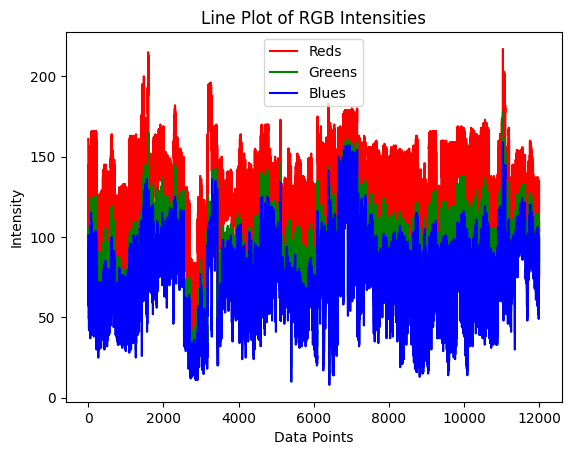

In [25]:
plt.plot(skin_colors['reds'], color='red', label='Reds')
plt.plot(skin_colors['greens'], color='green', label='Greens')
plt.plot(skin_colors['blues'], color='blue', label='Blues')
plt.xlabel('Data Points')
plt.ylabel('Intensity')
plt.title('Line Plot of RGB Intensities')
plt.legend()
plt.show()

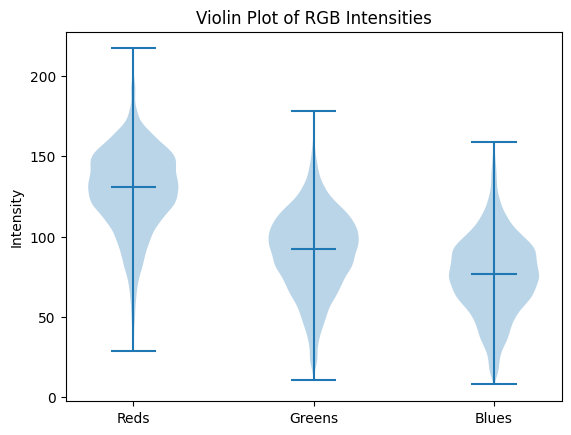

In [27]:
plt.violinplot(skin_colors.values(), showmedians=True)
plt.xticks([1, 2, 3], ['Reds', 'Greens', 'Blues'])
plt.ylabel('Intensity')
plt.title('Violin Plot of RGB Intensities')
plt.show()

## 2.3 Clustering the skin tones

Clustering the skin tones to 4 distinct clusters and naming them to use in the prompts.

In [65]:
# Combine the RGB values into a single array
rgb_values = np.vstack(tuple(skin_colors.values())).T

# Number of clusters
num_clusters = 4

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, n_init='auto', random_state=42)
cluster_labels = kmeans.fit_predict(rgb_values)
centers = kmeans.cluster_centers_.astype(int)
centers = np.stack([centers[2], centers[0], centers[3], centers[1]])
skin_color_tones = centers

# Define cluster names based on typical skin tone representation
cluster_names = {
    1: 'Dark',
    3: 'Brown',
    0: 'Light',
    2: 'Pale',
}

### 2.3.1 Visualize the cluster centers

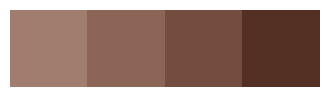

In [33]:
# Display color swatch
fig, ax = plt.subplots(figsize=(4, 1))

# Create a horizontal bar with the specified colors
ax.imshow(centers.reshape(1, -1, 3) / 255.0, aspect='auto')
ax.axis('off');

# 3. Creating crops-specific prompts based on the skin tones

In [36]:
# Initialize dictionary to store prompts
prompt_dict = {}

# Generate prompts and save to JSON file
for i in tqdm(range(1, 11995)):
    # Format image number
    image_number = str(i).zfill(4)
    
    # Assign prompt based on cluster label
    prompt_dict[image_number] = cluster_names[cluster_labels[i-1]]

  0%|          | 0/11994 [00:00<?, ?it/s]

# 4. Integrating images in the 'crops' folder with new masks and their respective prompts into a dataset

In [148]:
# Set base folder path
base_folder = Path(os.path.join(os.getcwd(), 'crops_masks'))

# Get a list of image paths
images_path = list(map(str, base_folder.glob("*[!_mask].png")))

# Extract base path
base_path = "/".join(images_path[0].split('/')[:-1])

# Initialize the transformer
t = transforms.ToTensor()

# Create a dataset from the provided information
ds = Dataset.from_dict(
    {
        "image": [t(Image.open(original_image_path)) for original_image_path in tqdm(images_path)],
        "conditioning_image": [t(Image.open(base_path + "/" + original_image_path.split('/')[-1].split('.')[0] + "_mask.png")) 
                               for original_image_path in tqdm(images_path)],
        "text": [
            "High-quality image depicting a part of human skin with a skin disease. " +
            "Highlight texture, color variations, lesions, and other notable features. " +
            f"The skin tone in this image is {prompt_dict[path.split('/')[-1].split('.')[0]]}."
            for path in tqdm(images_path)
        ],
    }
)

  0%|          | 0/11994 [00:00<?, ?it/s]

  0%|          | 0/11994 [00:00<?, ?it/s]

  0%|          | 0/11994 [00:00<?, ?it/s]

In [ ]:
# Split the dataset into train and test
custom_dataset = ds.train_test_split(test_size=0.2, shuffle=True)

# Save the dataset
custom_dataset.save_to_disk('skin_dataset')

# 5. Utilizing code from the GitHub repository to feed the dataset to the model

## 5.1 Configuration of accelerate module

Using a terminal follow these steps:

1. `pip install -r requirements.txt`
2. Initialize an 🤗Accelerate environment with:
    - `accelerate config`
3. Or for a default accelerate configuration without answering questions about your environment
    - `accelerate config default`
4. Or if your environment doesn't support an interactive shell e.g. a notebook run the following cell.

In [44]:
from accelerate.utils import write_basic_config
write_basic_config()

## 5.2 Training

### 5.2.1 Help menu of the training script

In [46]:
!accelerate launch train_controlnet.py --help

2023-12-05 17:57:46.675596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 17:57:46.896027: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 17:57:46.931257: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 17:57:48.202650: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

### 5.2.2 Lunch the training script 

In [ ]:
!export MODEL_DIR="runwayml/stable-diffusion-v1-5"
!export CONTROLNET_DIR="lllyasviel/sd-controlnet-seg"
!export VAE_DIR="stabilityai/sd-vae-ft-mse"
!export OUTPUT_DIR="models"
!export DATASET_NAME="skin_dataset"

!accelerate launch train_controlnet.py  \
--pretrained_model_name_or_path=$MODEL_DIR  \
--controlnet_model_name_or_path=$CONTROLNET_DIR \
--vae_model_name_or_path=$VAE_DIR
--output_dir=$OUTPUT_DIR  \
--dataset_name=$DATASET_NAME  \
--learning_rate=1e-5  \
--train_batch_size=8  \
--num_train_epochs=5

# 6. Loading and using the model

## 6.1 Loading the models into a pipeline

In [2]:
# Create a cache directory if it doesn't exist
try:
    os.mkdir("cache_dir")
except FileExistsError:
    pass

# Specify the device for computation (e.g., "cuda:1" for GPU)
device = "cuda:1"

# Load the pre-trained ControlNet model
controlnet = ControlNetModel.from_pretrained(
    "models/checkpoint-6000/controlnet",
    safety_checker=None,
    torch_dtype=torch.float16,
    cache_dir="cache_dir"
)
controlnet.to(device)

# Load the pre-trained AutoencoderKL model
vae = AutoencoderKL.from_pretrained(
    "stabilityai/sd-vae-ft-mse",
    safety_checker=None,
    torch_dtype=torch.float16,
    cache_dir="cache_dir"
)
vae.to(device)

# Create a StableDiffusionControlNetPipeline using the pre-trained models
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    vae=vae,
    controlnet=controlnet,
    safety_checker=None,
    requires_safety_checker=None,
    torch_dtype=torch.float16,
    cache_dir="cache_dir"
)
pipe.to(device)

# Use UniPCMultistepScheduler with the pipeline
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## 6.2 Showing some sample outputs

In [3]:
# Set the random seed for reproducibility
generator = torch.Generator().manual_seed(0)

# Mapping darkness levels to color prompts
color_prompt = {
    0: 'Pale',
    1: 'Light',
    2: 'Brown',
    3: 'Dark',
}

def show_4images(imgs):
    # Create a figure with a 1x4 grid
    fig, axs = plt.subplots(1, 4, figsize=(12, 5))

    # Loop through the images and display them in the grid
    for i in range(len(imgs)):
        axs[i].imshow(imgs[i])
        axs[i].axis('off')  # Turn off axis labels

    # Show the grid of images
    plt.show()
    
def prepare_input(path, darkness=0):
    """
    Prepare Input for Image Segmentation

    Args:
        path (str): Base path to the image and mask image.
        darkness (int): Darkness level (0 to 3) representing skin color prompt.

    Returns:
        tuple: A tuple containing the segmented image (Image object) and the corresponding color prompt.
    """
    # Open the mask image
    img = Image.open(path + '.png')
    # Open the mask image
    seg = Image.open(path + '_mask.png')

    # Uncomment the following lines if you want to manipulate the color channels based on darkness
    # image_cmask = cv2.imread(mask_path)
    # image_cmask = cv2.cvtColor(image_cmask, cv2.COLOR_BGR2RGB)
    # image_cmask[..., 0][image_cmask[..., 0]!=0] = skin_color_tone[darkness, 0]
    # image_cmask[..., 1][image_cmask[..., 1]!=0] = skin_color_tone[darkness, 1]
    # image_cmask[..., 2][image_cmask[..., 2]!=0] = skin_color_tone[darkness, 2]
    # seg = Image.fromarray(image_cmask)

    return img, seg, color_prompt[darkness] if 0 <= darkness < 4 else None

Pale


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Light


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Brown


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Dark


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

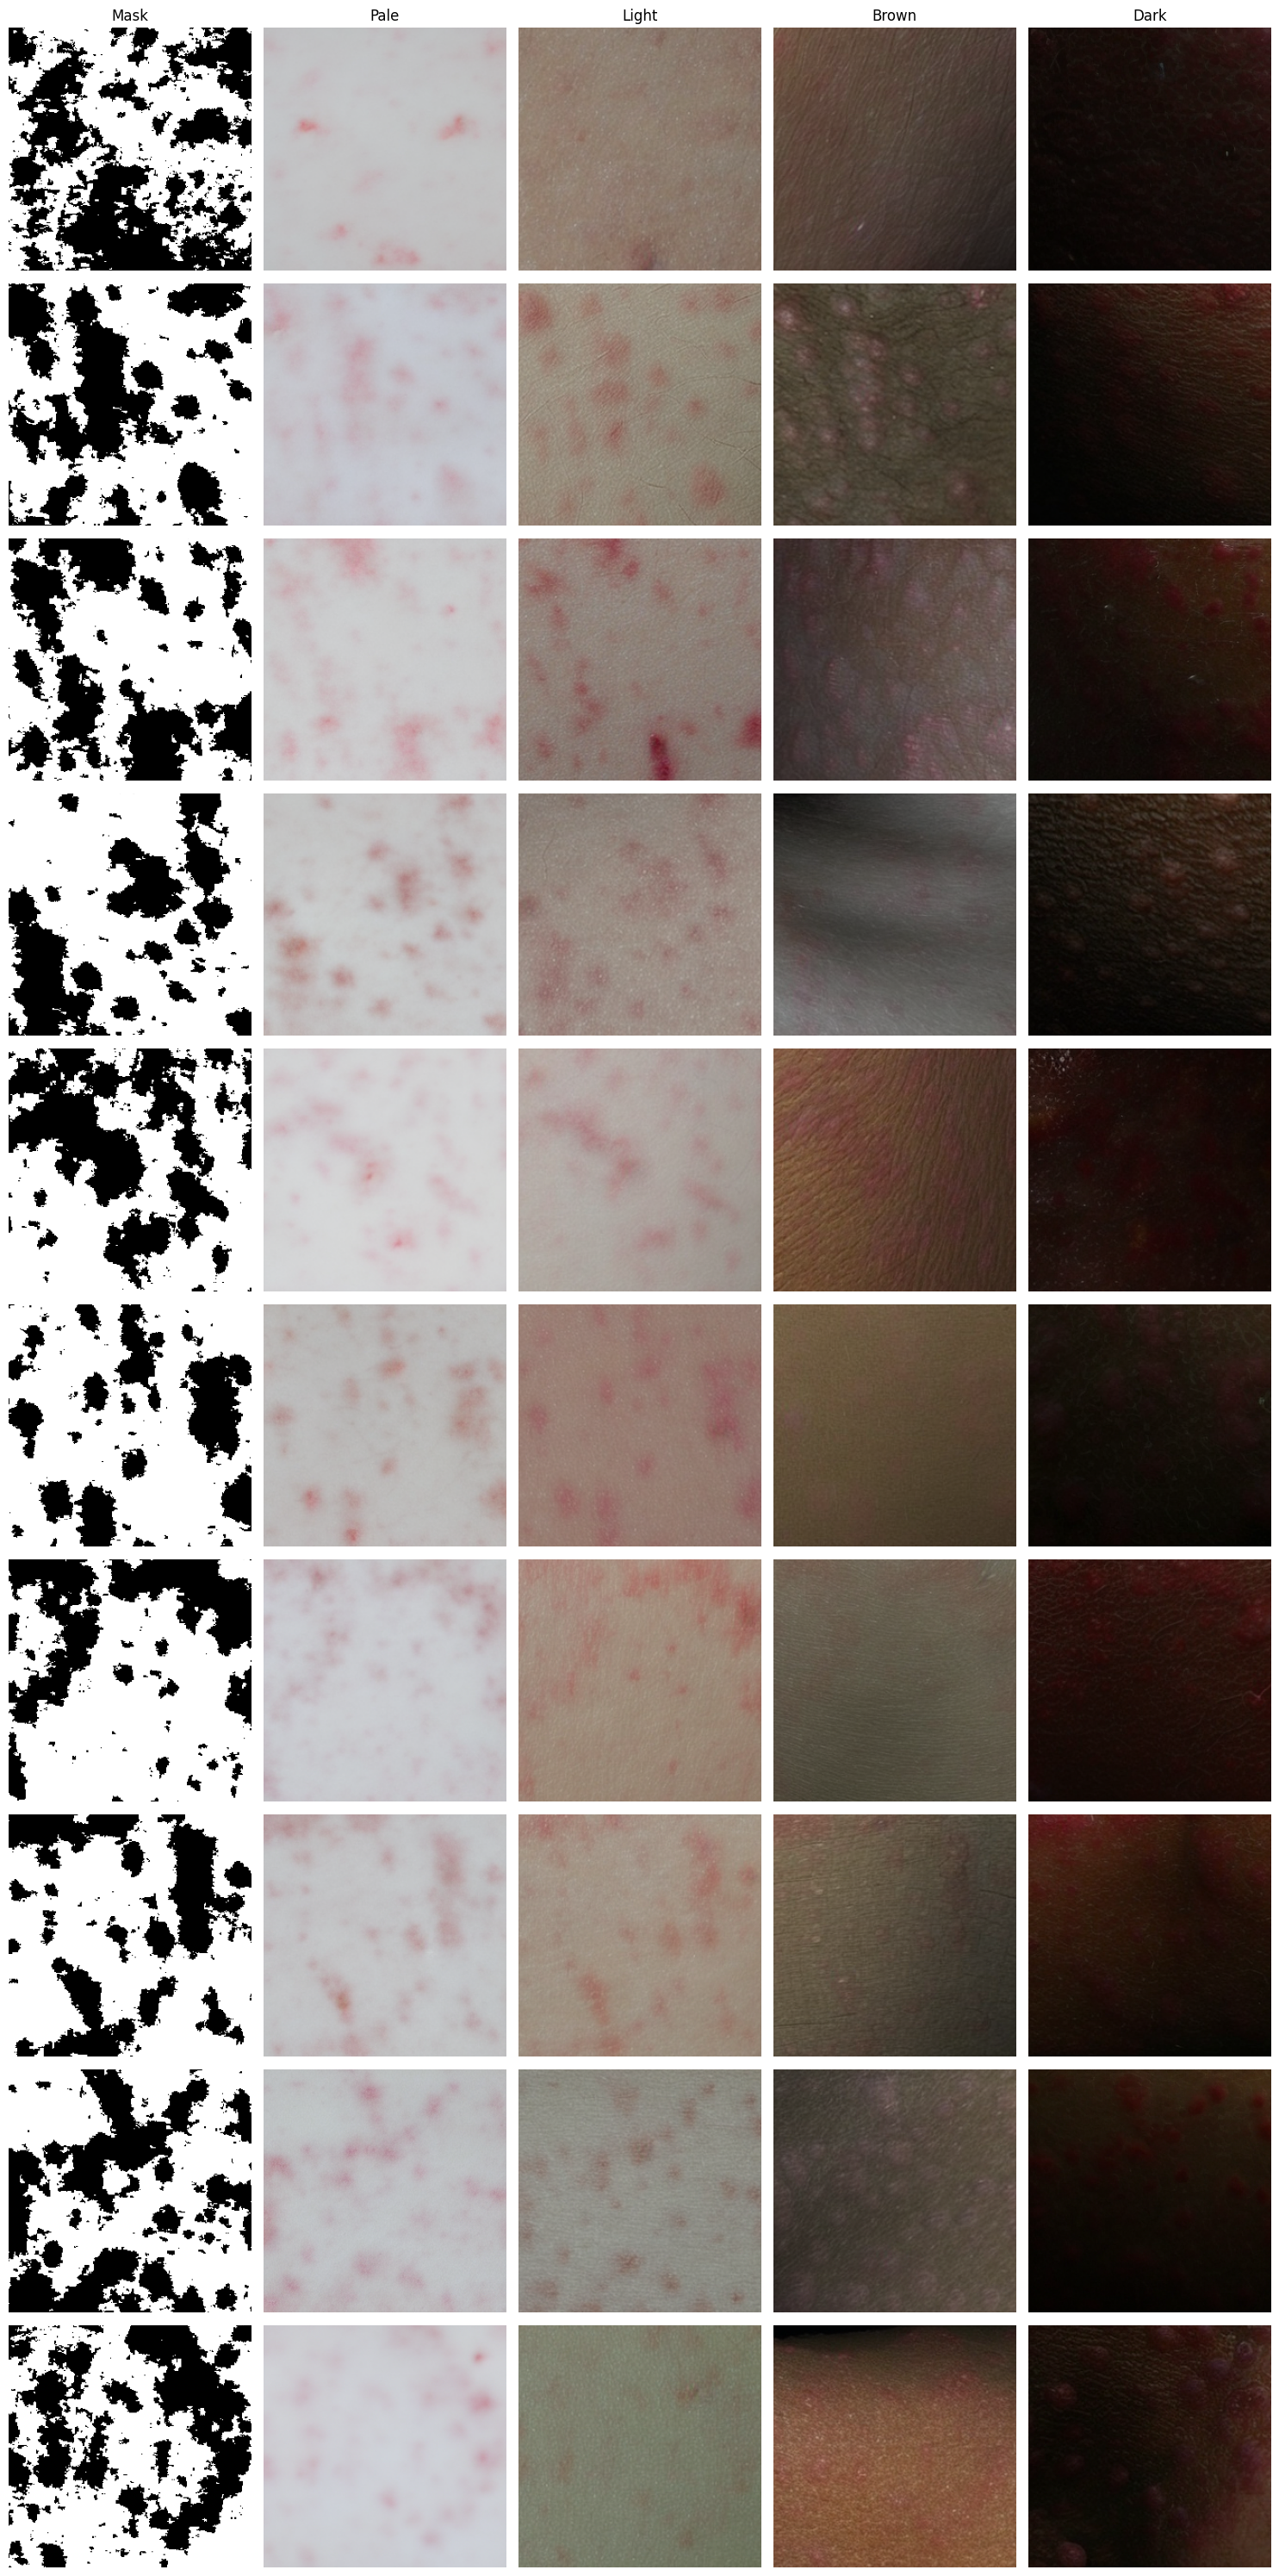

In [8]:
# Set the random seed for reproducibility
random.seed(10)

# Number of samples per darkness level
samples_per_darkness = 10

# Set up the subplots
fig, axes = plt.subplots(samples_per_darkness, 5, figsize=(15, 3*samples_per_darkness))

# Iterate over darkness levels and display outputs
for i in range(5):
    # Randomly choose 10 samples for each darkness level
    # random_samples = list(map(lambda x: x.zfill(4), map(str, random.sample(range(1, 11995), samples_per_darkness))))
    random_samples = [f"513{i}" for i in range(samples_per_darkness)]
    if i != 0:
        print(color_prompt[i-1])
    # Iterate over chosen samples
    for j, image_number in enumerate(random_samples):
        axes[j, i].axis('off')
        # Prepare input for each darkness level and sample
        # image_number = str(image_number).zfill(4)
        image, seg_image, color_pmt = prepare_input(f'crops_masks/{image_number}', darkness=i-1)

        if i == 0:
            axes[j, i].imshow(seg_image, cmap='gray')
            if j == 0:
                axes[j, i].set_title("Mask")
            continue

        # Generate output using the pipeline
        output = pipe(
            "High-quality image depicting a part of human skin with a skin disease. " +
            "Highlight texture, color variations, lesions, and other notable features. " +
            f"The skin tone in this image is {color_pmt}.",
            seg_image, 
            num_inference_steps=20,
            negative_prompt="bad lighting condition, parts of image is completely black, bad skin texture, generate healthy skin.",
            generator=generator
        ).images[0]

        # Display the output in a subplot
        axes[j, i].imshow(output)
        if j == 0:
            axes[j, i].set_title(color_pmt)

# Adjust layout and display the subplots
plt.tight_layout()
plt.savefig('all_samples.png')

### Testing the model using the test dataset

In [4]:
from torchmetrics.image.fid import FrechetInceptionDistance
from datasets import load_dataset, load_from_disk
from torch.utils.data import DataLoader

skin_dataset = load_from_disk('skin_dataset')

fid = FrechetInceptionDistance(normalize=True).to(device)
psnr = PeakSignalNoiseRatio().to(device)
ssim = StructuralSimilarityIndexMeasure().to(device)

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


In [5]:
# Assuming skin_dataset['test'] is your PyTorch dataset
test_dataset = skin_dataset['test']

# Specify batch size
batch_size = 64

# Calculate the total number of batches
total_batches = len(test_dataset) // batch_size


psnrs = []
ssims = []

# Iterate over batches
for i in range(total_batches):
    # Calculate start and end indices for the current batch
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size

    # Extract data for the current batch
    batch_data = test_dataset[start_idx:end_idx]
    
    reconstructed_images = pipe(
        batch_data['text'],
        batch_data['conditioning_image'],
        num_inference_steps=20,
        negative_prompt=["bad lighting condition, parts of image is completely black, bad skin texture, generate healthy skin."] * batch_size,
        generator=generator
    ).images
    reconstructed_images = torch.as_tensor(np.moveaxis(reconstructed_images, -1,1)).to(device)
    
    real_images = [batch_data["image"][i].convert('RGB') for i in range(batch_size)]
    real_images = torch.as_tensor(np.moveaxis(real_images, -1,1)).to(device)
    
    fid.update(reconstructed_images, real=False)
    fid.update(real_images, real=True)
    
    
    psnrs.append(psnr(reconstructed_images, real_images).item())
    ssims.append(ssim(reconstructed_images.to(torch.float32), real_images.to(torch.float32)).item())

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
print("Avg PSNR:", np.mean(psnrs))
print("Avg SSIM", np.mean(ssims))
out_fid = float(fid.compute())
print("FID:", out_fid)

Avg PSNR: 27.18837970011943
Avg SSIM 0.666768001543509
FID: 69.3786849975586
